# Initialization

In [1]:
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    print("using project root as working dir")

using project root as working dir


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

using cuda device


# Run

In [4]:
from src.graph import gen_graph
from dataclasses import asdict
from src.args import gridsearch_args, Args
from datetime import datetime
import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glob

from src.evaluator import Evaluator

In [5]:
# global seaborn settings
sns.set_context("paper")
sns.set_style("darkgrid", { "grid.color": ".8" })


palette = "Dark2"

In [ ]:
experiment = dict(
    key=datetime.now().strftime("%d-%m--%H-%M"),
    reps=3,
    skip_to=0,
    args=gridsearch_args(),
)
df_result = pd.DataFrame({})

run_len = len(experiment['args']) * experiment['reps']
for i, args in enumerate(experiment["args"]):
    # override args for specific test
    args.graph_type = "t_rgg"

    # skip to beginning of specified repetition block
    if i < int(experiment['skip_to'] / experiment['reps']):
        print(f"skipping {i * experiment['reps']} to {(i + 1) * experiment['reps'] - 1}")
        continue

    # run with repetitions
    for rep in range(experiment["reps"]):
        run_index = i * experiment['reps'] + rep
        print(f"running evaluator {run_index}/{run_len}")

        graph, dim = gen_graph(args)
        evaluator = Evaluator(
            graph=graph,
            dim=dim,
            args=args,
            writer_log_dir=f"runs/{experiment['key']}/s{args.graph_size}--es{args.epoch_graph_size}--a{args.epoch_graph_alpha}--{rep}",
            device=device
        )
        start_time = time.time()
        evaluator.train(
            optimizer=torch.optim.Adam(evaluator.net.parameters(), lr=1e-3),
            save_fig=False
        )
        end_time = time.time()
        test_loss, test_ap, test_f1 = evaluator.test(
            epoch=args.epochs,
            save_fig=True
        )

        df_result = pd.concat([
            df_result,
            pd.Series({
                # run meta
                "run_index": run_index,
                "run_time": end_time - start_time,
                # run results
                "loss": test_loss,
                "ap": test_ap,
                "f1": test_f1,
                # run args
                **asdict(args),
            }).to_frame().T
        ], ignore_index=True)

        # save results just in case the run fails mid run
        df_result.to_csv(f"./run-data/{experiment['key']}.csv.zip", index=False, compression=dict(method='zip', archive_name=f"{experiment['key']}.csv"))

# Print Results

In [ ]:
# mean score (bars)
df_result_mean_ap = df_result.groupby(["epoch_graph_alpha", "epoch_graph_size"], as_index=False)["ap"].mean().sort_values(by=['ap'])
# print(df_result_mean_ap)

sns.catplot(
    data=df_result_mean_ap,
    col="epoch_graph_size",
    x="epoch_graph_alpha",
    y="ap",
    palette=palette,
    kind = "bar"
)

In [ ]:
# score per epoch graph size and alpha (line with std)
sns.relplot(
    data=df_result, kind="line",
    hue="epoch_graph_size",
    x="epoch_graph_alpha",
    y="ap",
    errorbar="sd",
    palette=palette,
    aspect=2,
)

In [ ]:
# run time per graph and epoch graph size (line with std)
g = sns.relplot(
    data=df_result, kind="line",
    hue="note",
    x="graph_size",
    y="run_time",
    errorbar="sd",
    palette="Dark2",
    aspect=2,
)
g.set_axis_labels("Graph Size", "Run Time (in seconds)")
g._legend.set_title("Variant")
g.figure.savefig("./out/run_time.pdf")

In [ ]:
# score
g = sns.relplot(
    data=df_result, kind="line",
    hue="note",
    x="epoch_graph_alpha",
    y="ap",
    errorbar="sd",
    palette=palette,
    aspect=2,
)
g.set_axis_labels("Epoch Alpha", "Average Precision")
g._legend.set_title("Variant")
plt.savefig('./out/ap.pdf')

In [ ]:
# score per time
df_result["rel_ap"] = df_result['ap'] / df_result['run_time']
g = sns.relplot(
    data=df_result, kind="line",
    hue="note",
    x="graph_size",
    y="rel_ap",
    errorbar="sd",
    palette=palette,
    aspect=2,
)
g.set_axis_labels("Graph Size", "Average Precision / Run Time (in seconds)")
g._legend.set_title("Variant")
plt.savefig('./out/rel_ap.pdf')

/tmp/ipykernel_2779/2220523995.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data=df_hm.pivot("graph_size", "epoch_graph_size", "ap"),
/tmp/ipykernel_2779/2220523995.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data=df_hm.pivot("graph_size", "epoch_graph_size", "ap"),
/tmp/ipykernel_2779/2220523995.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data=df_hm.pivot("graph_size", "epoch_graph_size", "ap"),


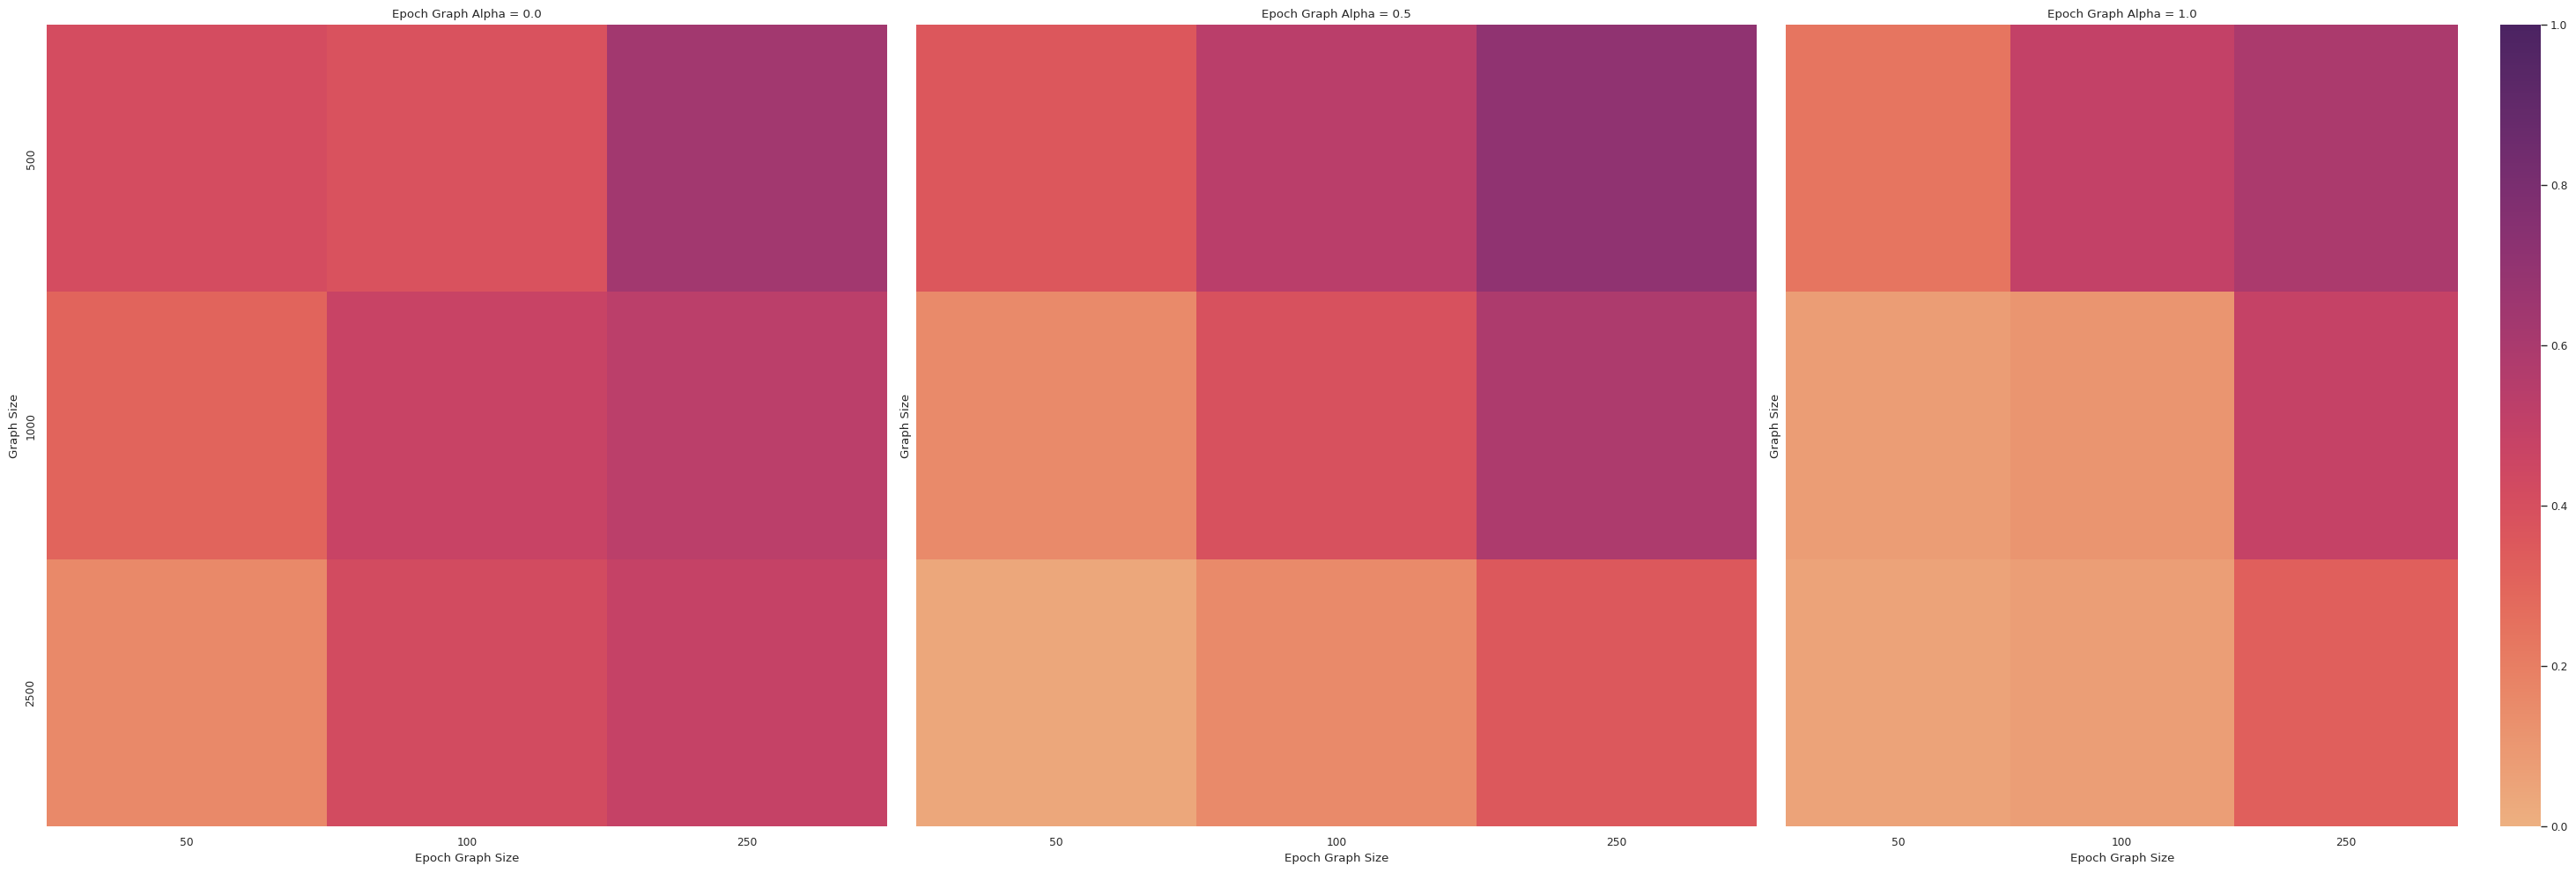

In [15]:
# plot grid search result
fig, axs = plt.subplots(ncols=3, figsize=(10 * 3, 10), sharey='all')
for i, a in enumerate([0.0, 0.5, 1.0]):
    df_hm = df_result\
        .loc[df_result["epoch_graph_alpha"] == a]\
        .groupby(["graph_size", "epoch_graph_size"], as_index=False)["ap"].mean()
    g = sns.heatmap(
        vmin=0.0,
        vmax=1.0,
        data=df_hm.pivot("graph_size", "epoch_graph_size", "ap"),
        ax=axs[i],
        cbar=i==2,
        cmap="flare",
    )
    axs[i].set_title(f"Epoch Graph Alpha = {a}")
    g.set(xlabel="Epoch Graph Size", ylabel="Graph Size")
plt.tight_layout()
plt.savefig('./out/grid_search_girg.pdf')

# Load data frames

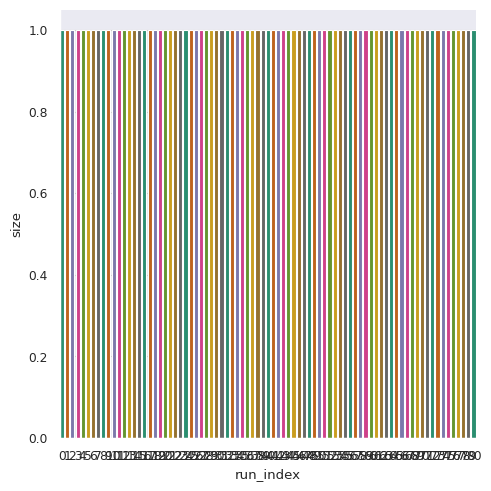

In [13]:
# load data frame from folder
path = "./results/girg_grid_search"
all_files = glob.glob(os.path.join(path, "*.csv.zip"))
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

df_result_count = df.groupby(["run_index"], as_index=False)["run_index"].size()
sns.catplot(
    data=df_result_count,
    x="run_index",
    y="size",
    palette=palette,
    kind="bar"
)

In [ ]:
# append data frame
df_result = pd.concat((df_result, df), ignore_index=True)

In [14]:
# use data frame
df_result = df

In [ ]:
# save data frame
df_result.to_csv(os.path.join(path, "saved.csv.zip"), index=False, compression=dict(method='zip', archive_name=f"saved.csv"))